In [837]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib as mpl
import scipy as sp
import IPython
import sklearn
%matplotlib inline

In [838]:
#read the training  testing data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [839]:
#Will be used for submitting the results later
submission=test['Loan_ID'].copy()

In [840]:
train.shape

(614, 13)

In [841]:
#Checking data types of features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [842]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [843]:
#Counting the number of Yes and No
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [844]:
#loan id is useless
train.drop('Loan_ID',axis=1,inplace=True)
test.drop('Loan_ID',axis=1,inplace=True)
train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

array([[<AxesSubplot:title={'center':'ApplicantIncome'}>,
        <AxesSubplot:title={'center':'CoapplicantIncome'}>],
       [<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Loan_Amount_Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>, <AxesSubplot:>]],
      dtype=object)

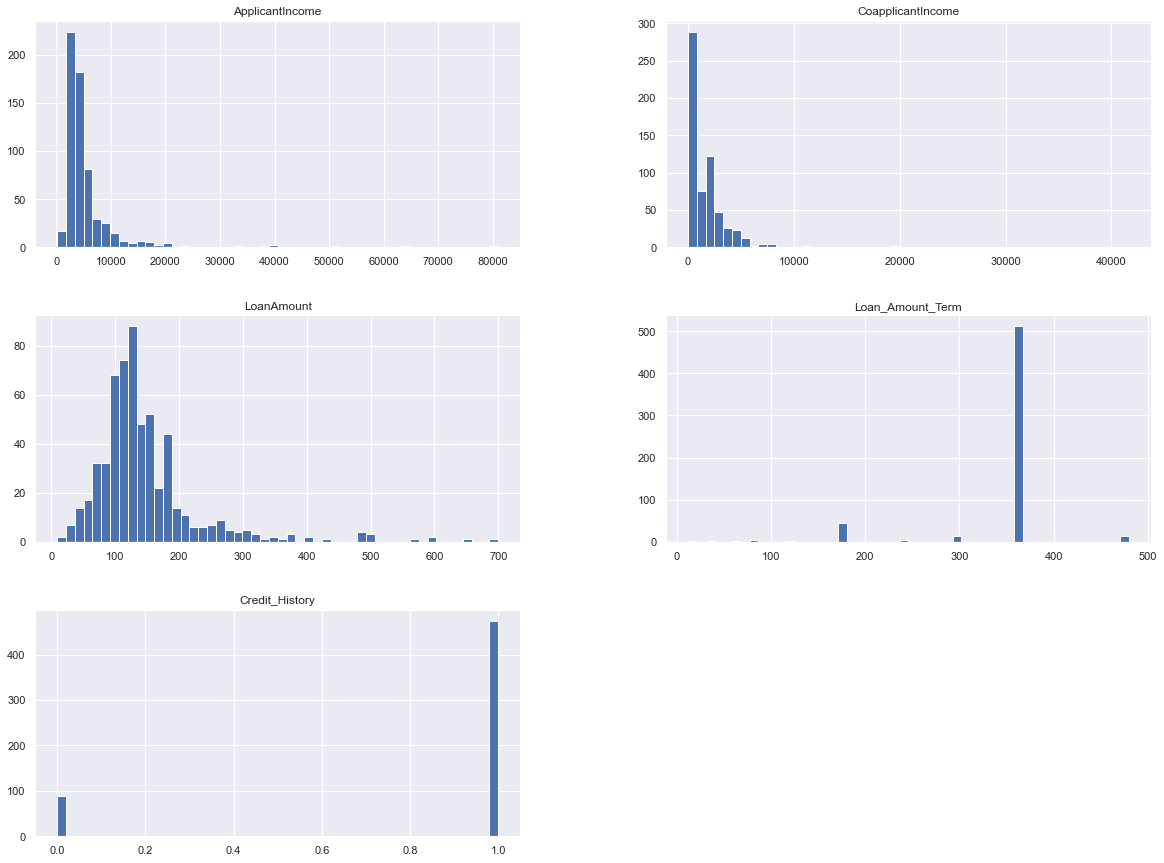

In [845]:
#Data Visualization of numeric features
train.hist(bins=50,figsize=(20,15))
#According to the graph ApplicantIncome and CoapplicantIncome has a few outliers, credit history only has 2 values

array([[<AxesSubplot:xlabel='ApplicantIncome', ylabel='ApplicantIncome'>,
        <AxesSubplot:xlabel='CoapplicantIncome', ylabel='ApplicantIncome'>,
        <AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='ApplicantIncome'>],
       [<AxesSubplot:xlabel='ApplicantIncome', ylabel='CoapplicantIncome'>,
        <AxesSubplot:xlabel='CoapplicantIncome', ylabel='CoapplicantIncome'>,
        <AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='CoapplicantIncome'>],
       [<AxesSubplot:xlabel='ApplicantIncome', ylabel='LoanAmount'>,
        <AxesSubplot:xlabel='CoapplicantIncome', ylabel='LoanAmount'>,
        <AxesSubplot:xlabel='LoanAmount', ylabel='LoanAmount'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='LoanAmount'>],
       [<AxesSubplot:xlabel='ApplicantIncome', ylabel='Loan_Amount_Term'>,
        <AxesSubplot:xlabel='CoapplicantIncome', yla

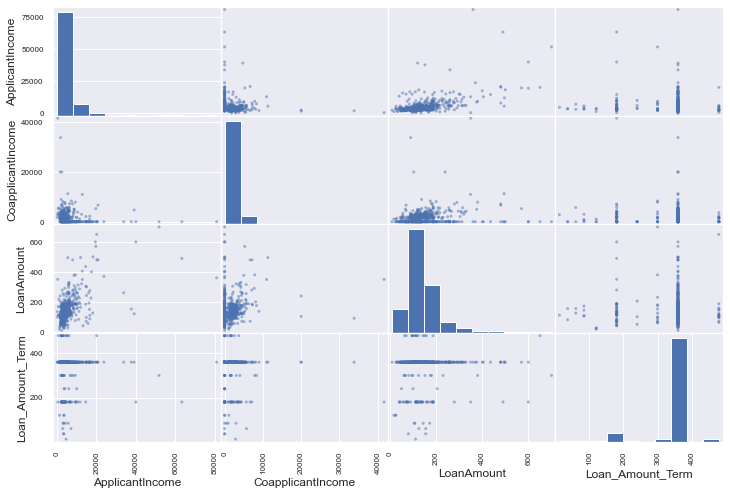

In [846]:
#Finding correlation among all numerical features
corr_mat=train.corr()
from pandas.plotting import scatter_matrix
fetures=train[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']]
scatter_matrix(fetures,figsize=(12,8))

<AxesSubplot:xlabel='Education', ylabel='count'>

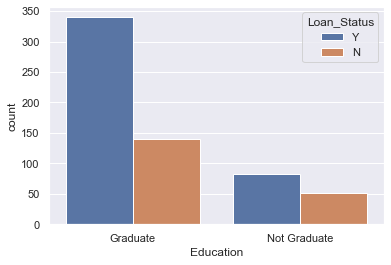

In [847]:
#Plotting Loan_status against every categorical feature
import seaborn as sns
sns.set()
sns.countplot(x='Education',hue='Loan_Status',data=train)
#Graduate have higher chance of getting loan

<AxesSubplot:xlabel='Dependents', ylabel='count'>

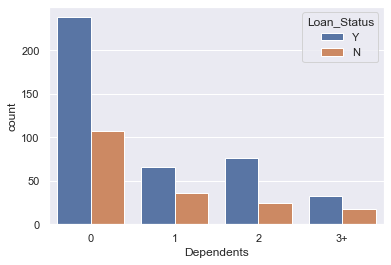

In [848]:
sns.countplot(x='Dependents',hue='Loan_Status',data=train)
#People with less dependents apply for loans more

<AxesSubplot:xlabel='Gender', ylabel='count'>

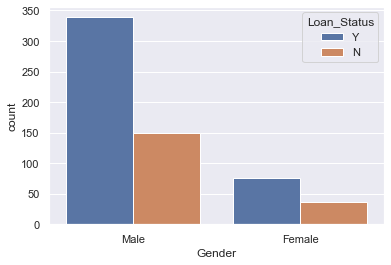

In [849]:
sns.countplot(x='Gender',hue='Loan_Status',data=train)

<AxesSubplot:xlabel='Married', ylabel='count'>

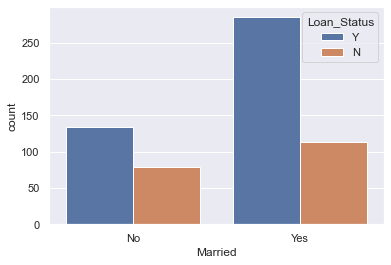

In [850]:
sns.countplot(x='Married',hue='Loan_Status',data=train)
#Unmarried people have lower chance of getting loan approval compared to married

<AxesSubplot:xlabel='Self_Employed', ylabel='count'>

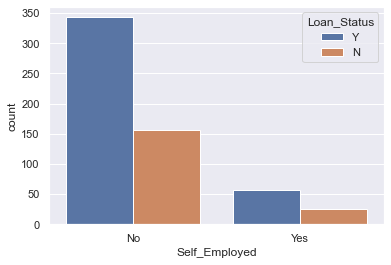

In [851]:
sns.countplot(x='Self_Employed',hue='Loan_Status',data=train)


<AxesSubplot:xlabel='Credit_History', ylabel='count'>

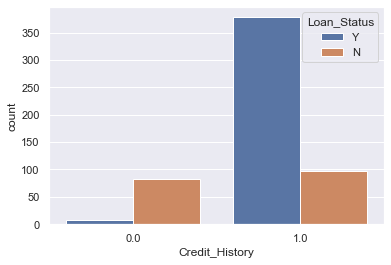

In [852]:
sns.countplot(x='Credit_History',hue='Loan_Status',data=train)
#people with credit history 1 have higher chance of getting loan approval

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

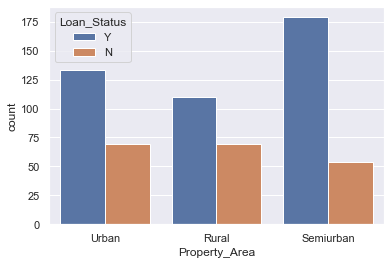

In [853]:
sns.countplot(x='Property_Area',hue='Loan_Status',data=train)
#Semiurban household have the highest chance of getting loan approval

<AxesSubplot:xlabel='ApplicantIncome', ylabel='count'>

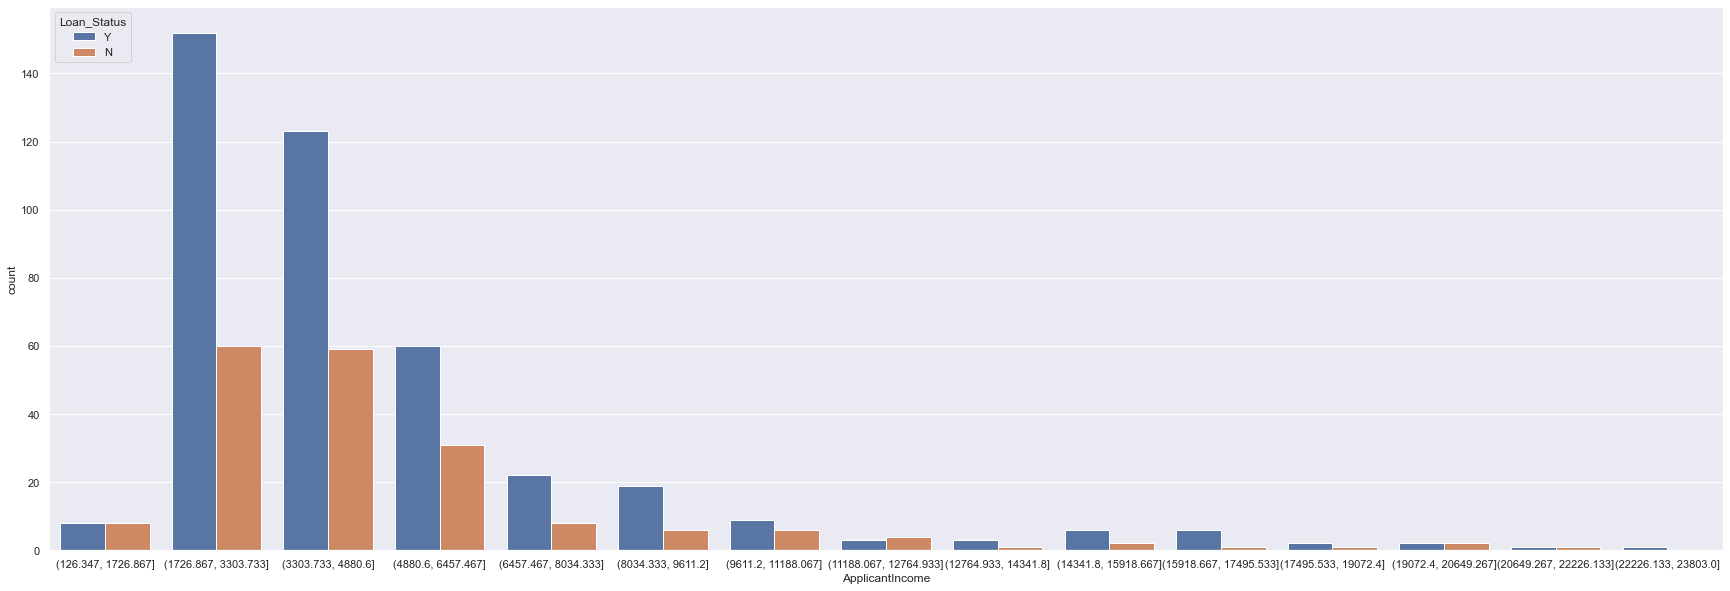

In [854]:
#Dividing people by income to find distribution of loan applicants and loan approval by income
df=train
#remove outliers
df=df[df['ApplicantIncome']<30000]
df2=df
#bin applicant income into 15 bins
df=pd.cut(df['ApplicantIncome'],bins=15)
#concat the result with loan_status
df2=pd.concat([df,df2['Loan_Status']],axis=1)
plt.figure(figsize=(30,10))
sns.countplot(x='ApplicantIncome',hue='Loan_Status',data=df2)


<AxesSubplot:xlabel='CoapplicantIncome', ylabel='count'>

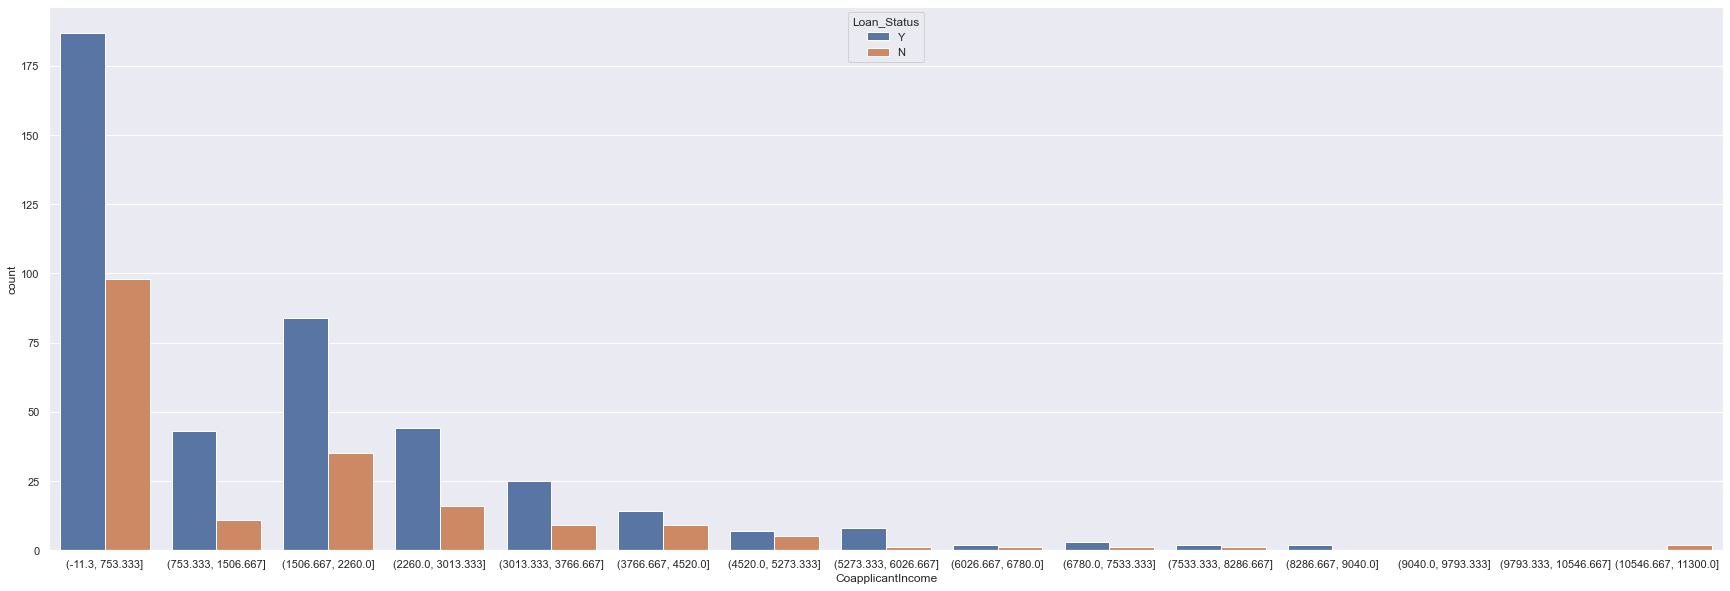

In [855]:
#Dividing people by coapplicantincome to find distribution of loan applicants and loan approval by coapplicantincome
df=train
#remove outliers
df=df[df['CoapplicantIncome']<15000]
df2=df
#bin Coapplicant income into 15 bins
df=pd.cut(df['CoapplicantIncome'],bins=15)
#concat the result with loan_status
df2=pd.concat([df,df2['Loan_Status']],axis=1)
plt.figure(figsize=(30,10))
sns.countplot(x='CoapplicantIncome',hue='Loan_Status',data=df2)

<AxesSubplot:xlabel='LoanAmount', ylabel='count'>

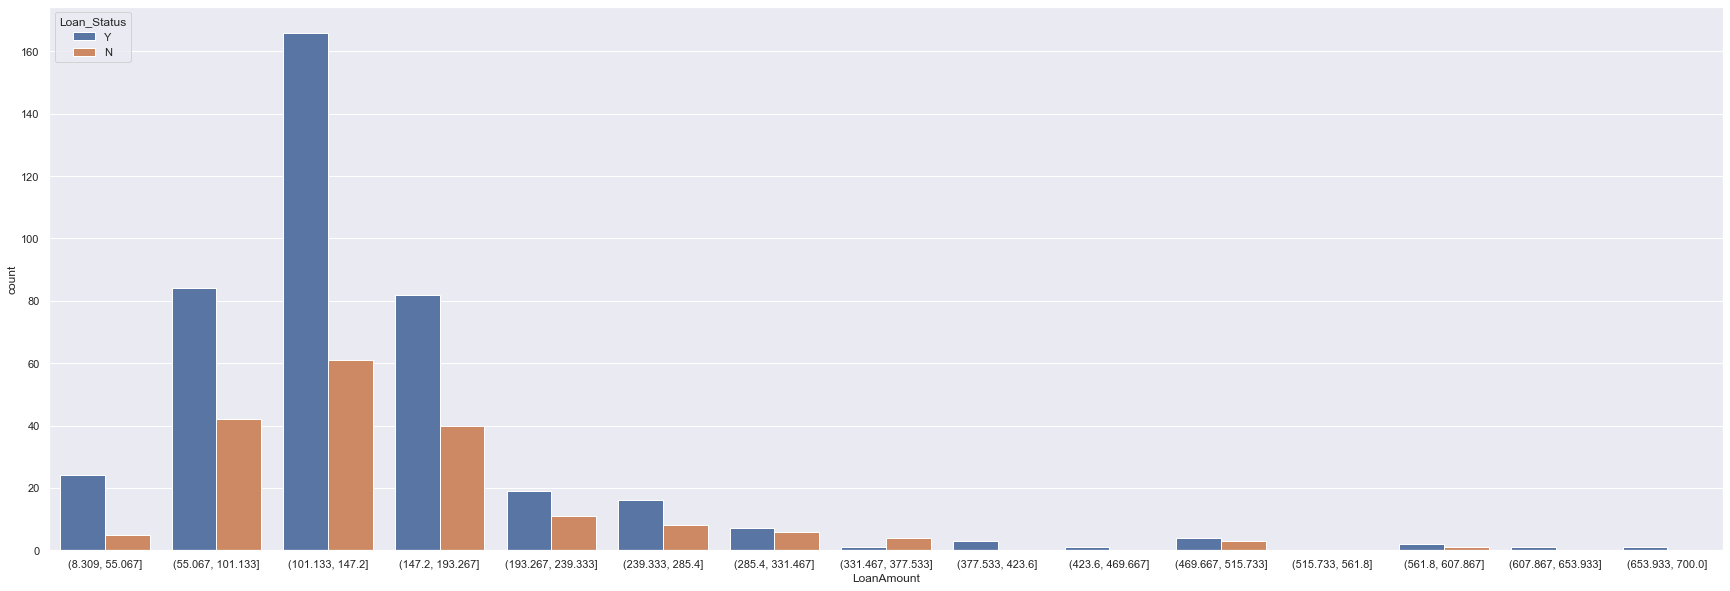

In [856]:
df=train
df=pd.cut(df['LoanAmount'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='LoanAmount',hue='Loan_Status',data=df2)

<AxesSubplot:xlabel='Loan_Amount_Term', ylabel='count'>

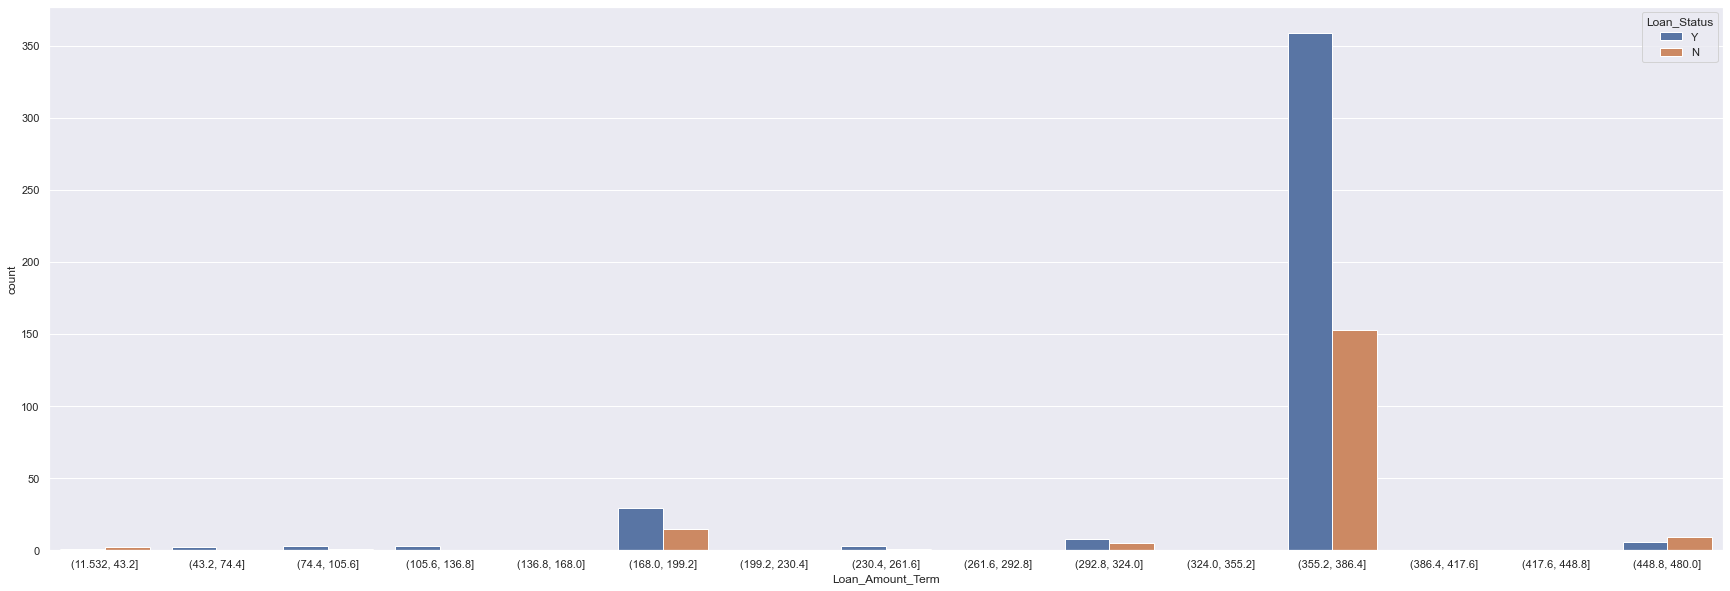

In [857]:
df=train
df=pd.cut(df['Loan_Amount_Term'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='Loan_Amount_Term',hue='Loan_Status',data=df2)

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

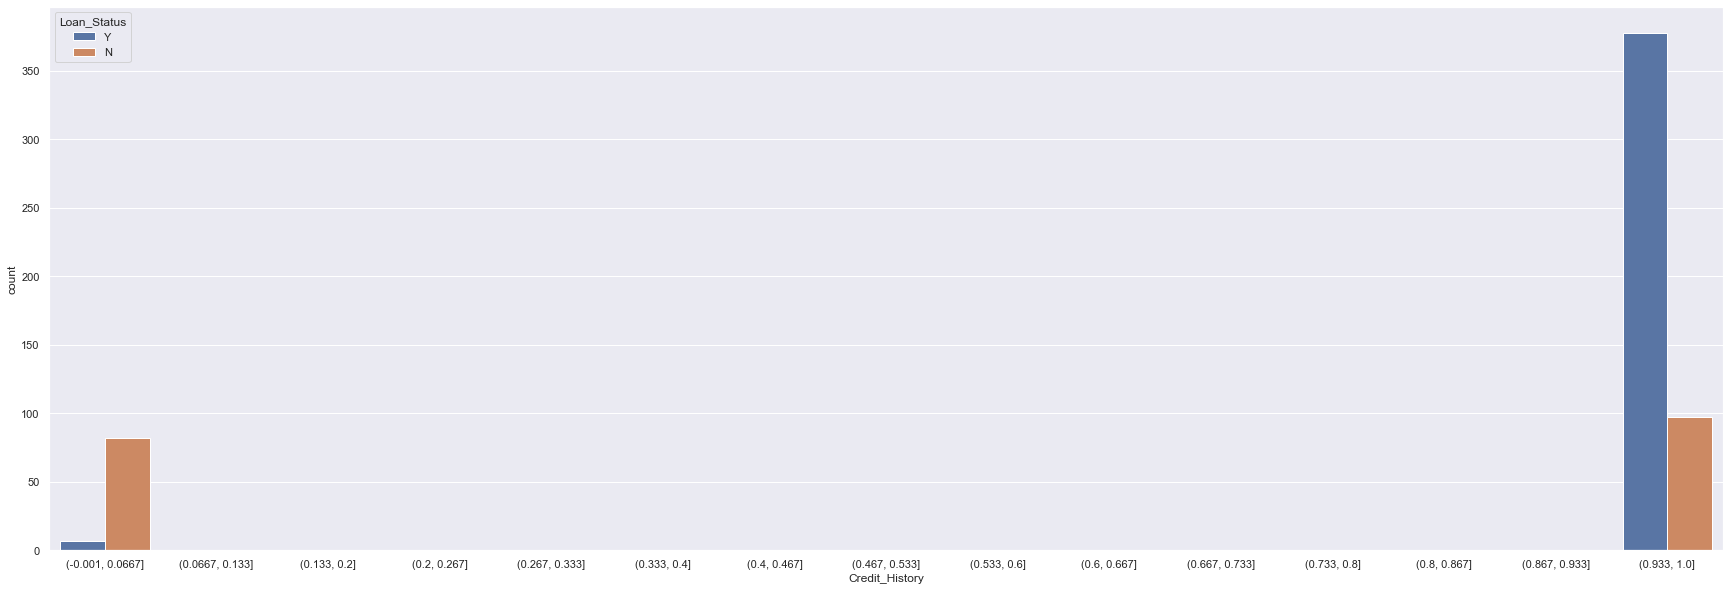

In [858]:
df=train
df=pd.cut(df['Credit_History'],bins=15)
df2=pd.concat([df,train['Loan_Status']],axis=1)
df2
plt.figure(figsize=(30,10))
sns.countplot(x='Credit_History',hue='Loan_Status',data=df2)

In [859]:
#Using label encoder to encode Loan_Status
from sklearn.preprocessing import LabelEncoder
df=train
le=LabelEncoder()
df2=le.fit_transform(df['Loan_Status'])
df2=pd.DataFrame(df2)
df2.columns=['Status']
df=pd.concat([df,df2],axis=1)


In [860]:
#Correlation of different features with loan_status
corr_matrix=df.corr()
corr_matrix['Status'].sort_values(ascending=False)

Status               1.000000
Credit_History       0.561678
ApplicantIncome     -0.004710
Loan_Amount_Term    -0.021268
LoanAmount          -0.037318
CoapplicantIncome   -0.059187
Name: Status, dtype: float64

In [861]:
#Seperating features and target variable
y_train=train["Loan_Status"].copy()
X_train=train.drop(columns=['Loan_Status'])
X_test=test
X_test.shape

(367, 11)

In [862]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [863]:
y_train.head()

0    Y
1    N
2    Y
3    Y
4    Y
Name: Loan_Status, dtype: object

In [864]:
#Finding count of null values of all features
#train.dropna(subset=['Loan_Status'])
X_train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [865]:
#fill null object columns with mode of that column
X_train[['Gender','Married','Dependents','Self_Employed','Credit_History']]=X_train[['Gender','Married','Dependents','Self_Employed','Credit_History']].apply(lambda x:x.fillna(x.value_counts().index[0]))

X_test[['Gender','Married','Dependents','Self_Employed','Credit_History']]=X_test[['Gender','Married','Dependents','Self_Employed','Credit_History']].apply(lambda x:x.fillna(x.value_counts().index[0]))
X_train.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
dtype: int64

In [866]:
#filling numerical features having null values
from sklearn.impute import SimpleImputer
imp=SimpleImputer(strategy="median")
df=X_train[['LoanAmount','Loan_Amount_Term']]
imp.fit(df)
imp.statistics_
temp=imp.transform(df)
train_a=pd.DataFrame(temp,columns=df.columns,index=df.index)

In [867]:
train_a.describe()
X_train[['LoanAmount','Loan_Amount_Term']]=train_a
X_train.isnull().sum()
#Verifying if null values have been filled

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [868]:
#filling null values for test data
df=X_test[['LoanAmount','Loan_Amount_Term']]
imp.fit(df)
imp.statistics_
temp=imp.transform(df)
train_a=pd.DataFrame(temp,columns=df.columns,index=df.index)
X_test[['LoanAmount','Loan_Amount_Term']]=train_a

In [869]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 52.9+ KB


In [870]:
#transform object datatype to categorcial using one hot encoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()
cat_features=X_train[['Gender','Married','Dependents','Education','Self_Employed','Property_Area']]
cat_features.describe()
train_cat=cat_encoder.fit_transform(cat_features)
train_cat

<614x15 sparse matrix of type '<class 'numpy.float64'>'
	with 3684 stored elements in Compressed Sparse Row format>

In [871]:
cat_encoder.categories_
#categories encoded

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['0', '1', '2', '3+'], dtype=object),
 array(['Graduate', 'Not Graduate'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Rural', 'Semiurban', 'Urban'], dtype=object)]

In [872]:
train_cat.shape
train_cat.toarray()
#output after one hot encoding

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [873]:
#converting output of one hot encoding from arrays to pandas dataframe 
df=pd.DataFrame(train_cat.toarray())
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [874]:
#Repeating the same for test dataset
cat_features=X_test[['Gender','Married','Dependents','Education','Self_Employed','Property_Area']]
test_cat=cat_encoder.fit_transform(cat_features)
df2=pd.DataFrame(test_cat.toarray())

In [875]:
#concat the encoded dataset to the original dataset
train_final=pd.concat([X_train,df],axis=1)
train_final.head()
test_final=pd.concat([X_test,df2],axis=1)

In [876]:
#removing the categorical features which have been one hot encoded
X_train=train_final.drop(columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'])

X_test=test_final.drop(columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'])
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,5849,0.0,128.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4583,1508.0,128.0,360.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3000,0.0,66.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2583,2358.0,120.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,6000,0.0,141.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [877]:
#Splitting the training dataset into training set and validation set
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=54)

In [878]:
#Applying logistic regression
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(max_iter=1000,random_state=7)
log_reg.fit(X_train,y_train)
log_reg.score(X_train,y_train)

0.8152173913043478

In [879]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#prediciting on validation set and making its confusion matrix
pred=log_reg.predict(X_val)
confusion_matrix(y_val, pred)

array([[11, 10],
       [ 1, 40]], dtype=int64)

In [880]:
#computing accuracy score on validation set
accuracy_score(y_val,pred)

0.8225806451612904

In [881]:
#computing recall score on validation set
#using weighted param to  calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance
recall_score(y_val,pred,average='weighted')

0.8225806451612904

In [882]:
#computing precision score on validation set
precision_score(y_val,pred,average='weighted')

0.8395161290322581

In [883]:
#computing f1 score on validation set
f1_score(y_val,pred,average='weighted')

0.8071605813541297

In [884]:
#Applying the model on test dataset to predict loan_status
pred=log_reg.predict(X_test)
pred=pd.DataFrame({'Loan_Status':pred})
pred=pd.concat([submission,pred],axis=1)
#Exporting the predictions to csv file
pred.to_csv('my_sub11.csv',index=False)
pred.shape

(367, 2)

In [885]:
#Applying DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dt_clf=DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train,y_train)
#importance given by the model to each feature
dt_clf.feature_importances_

array([0.17725417, 0.11851309, 0.14990322, 0.03262883, 0.28423402,
       0.02704723, 0.00564842, 0.00328419, 0.01835735, 0.02490972,
       0.01987705, 0.0104848 , 0.00847263, 0.02068047, 0.04374217,
       0.01016715, 0.01644111, 0.00987499, 0.0154669 , 0.00301249])

In [886]:
#computing accuracy score on validation set
pred=dt_clf.predict(X_val)
accuracy_score(y_val,pred)

0.7580645161290323

In [887]:
#computing recall score on validation set
recall_score(y_val,pred,average='weighted')

0.7580645161290323

In [888]:
#computing f1 score on validation set
f1_score(y_val,pred,average='weighted')

0.7565715260728199

In [889]:
#computing precision score on validation set
precision_score(y_val,pred,average='weighted')

0.7554915514592934

In [890]:
#Applying the model on test dataset to predict loan_status
pred=dt_clf.predict(X_test)
pred=pd.DataFrame({'Loan_Status':pred})
pred=pd.concat([submission,pred],axis=1)
#Exporting the predictions to csv file
pred.to_csv('my_sub2.csv',index=False)
pred.shape

(367, 2)

In [891]:
#Applying Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(n_estimators=500,max_depth=4,random_state=7)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_val)
#Computing accuracy score on validation set
accuracy_score(y_val,pred)

0.8225806451612904

In [892]:
rf_clf.feature_importances_

array([0.0787152 , 0.07231733, 0.08383713, 0.04225175, 0.50042524,
       0.00692916, 0.00731251, 0.01744373, 0.01651203, 0.00963438,
       0.00961955, 0.01044562, 0.01063987, 0.02088324, 0.01916219,
       0.00558934, 0.00701392, 0.03152613, 0.04050657, 0.00923511])

In [893]:
#computing recall score on validation set
recall_score(y_val,pred,average='weighted')

0.8225806451612904

In [894]:
#computing precision score on validation set
precision_score(y_val,pred,average='weighted')

0.8395161290322581

In [895]:
#computing f1 score on validation set
f1_score(y_val,pred,average='weighted')

0.8071605813541297

In [896]:
#Applying the model on test dataset to predict loan_status
pred=rf_clf.predict(X_test)
pred=pd.DataFrame({'Loan_Status':pred})
pred=pd.concat([submission,pred],axis=1)
#Exporting the predictions to csv file
pred.to_csv('my_sub3.csv',index=False)
pred.shape

(367, 2)